# Jacobian with respect to weights of a one dimensional decoder

Here, we take a deep decoder with fixed linear upsampling filters and compute the Jacobian. We then plot the leading singular vectors of the Jacobian and track how they behave over time.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    torch.cuda.set_device(0)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


num GPUs 3


## Functions required for one-dimensional deep decoder

In [2]:
def pad_circular1d(x, pad):
    x = torch.cat([x, x[0:pad]])
    x = torch.cat([x[-2 * pad:-pad], x])
    return x

class Pad1d(torch.nn.Module):
    def __init__(self, pad):
        super(Pad1d, self).__init__()
        self.pad = pad
        
    def forward(self, x):
        shape = [1,x.shape[1],x.shape[2]+2*self.pad]
        xx = Variable(torch.zeros(shape)).type(dtype)
        for i in range(x.shape[1]):
            xx[0,i] = pad_circular1d(x[0,i],self.pad)
        return xx # pad_circular1d(x, self.pad)

y = Variable( torch.tensor([1,2,3,4]) ).type(dtype)
yy = Variable( torch.tensor([[[1,2,3,4]]]) ).type(dtype)

pad = 1
shape = [1,2,yy.shape[2]+2*pad]
py = Variable(torch.zeros(shape)).type(dtype)
py[0,0] = pad_circular1d(yy[0,0],pad)
print(py)

tensor([[[4., 1., 2., 3., 4., 1.],
         [0., 0., 0., 0., 0., 0.]]], device='cuda:0')


In [3]:
def print_filters(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            print(m.weight.data.cpu().numpy())  

def plot_gradients(out_grads):
    for i,g in enumerate(out_grads):
        plt.semilogy(g,label=str(i)) 
    plt.legend()
    plt.show()

In [4]:
def conv(in_f, out_f, kernel_size, stride=1,bias=False,pad=True):
    '''
    Circular convolution
    '''
    to_pad = int((kernel_size - 1) / 2)
    if pad:
        padder = Pad1d(to_pad)
    else:
        padder = None

    #convolver = nn.utils.weight_norm(nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias), name='weight')
    convolver = nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias)
    
    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers).type(dtype)


# test conv
n = 8
shape = [1,1,n]
y = Variable( torch.tensor(np.array([[[1,2,3,4,5,6,7,8]]])) ).type(dtype)
print(y)

cl = conv(1, 1, 5, stride=1,bias=False,pad=True)
#print( cl.convolver.weights.data )

def initialize(net):
    for m in net.modules():
        if isinstance(m, nn.Conv1d):
            if m.weight.data.shape[2]>1:
                m.weight.data[0,0,0] = 0
                m.weight.data[0,0,1] = 1
                m.weight.data[0,0,2] = 1
                m.weight.data[0,0,3] = 0
                m.weight.data[0,0,4] = 0

cl.apply( initialize )
print_filters(cl)
print("y:", y)

out = cl(y)
print("result: ", out)
# works correctly..

tensor([[[1., 2., 3., 4., 5., 6., 7., 8.]]], device='cuda:0')
[[[0. 1. 1. 0. 0.]]]
y: tensor([[[1., 2., 3., 4., 5., 6., 7., 8.]]], device='cuda:0')
result:  tensor([[[ 9.,  3.,  5.,  7.,  9., 11., 13., 15.]]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


## Define deep decoder with last, irrelevant layer fixed to scalars

In [5]:
def decnet(
        num_output_channels=1, 
        num_channels_up=[1]*5, 
        filter_size_up=2,
        act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
        modeout = "none",
        upsample_mode='none',
        scale_factor=2,
        ):
    
    num_channels_up = num_channels_up + [num_channels_up[-1]]
    n_scales = len(num_channels_up) 
    
    model = nn.Sequential()

    for i in range(len(num_channels_up)-1):
        
        if upsample_mode!='none':
            model.add(nn.Upsample(scale_factor=scale_factor, mode=upsample_mode))
        
        model.add(conv( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1))
        if act_fun != None:
            model.add(act_fun)
        #model.add(ChannelNormalization(num_channels_up[i],mode=mode))
        model.add( nn.BatchNorm1d( num_channels_up[i] ,affine=True) )
      
    if modeout != "none":
        model.add( nn.BatchNorm1d( num_channels_up[i+1] ,affine=True) )
    #model.add(conv( num_channels_up[-1], num_output_channels, 1,bias=True,pad=False))
    
    model.add(conv( num_channels_up[-1], num_output_channels, 1,bias=False,pad=False))
    model[-1][0].weight.requires_grad = False
    a = int( num_channels_up[-1] /2 )
    w = np.concatenate( (np.ones(a), -np.ones(a) ) ) / np.sqrt(2*a)
    model[-1][0].weight.data = torch.tensor(w[None,:,None])
    
    #model.add(nn.Sigmoid())

    return model

## Function for fitting a deep decoder to measurements

In [6]:
def get_ni(num_channels,n,upsamplefactor):
    length = int(n / upsamplefactor)
    shape = [1,num_channels[0], length ]
    print("input shape : ", shape)
    net_input = Variable(torch.zeros(shape)).type(dtype)
    net_input.data.uniform_()
    return net_input
    
def fit(net,
        y,
        y_clean,
        num_channels,
        net_input = None,
        num_iter = 5000,
        LR = 0.01,
        upsamplefactor=1,
       ):

    if net_input is not None:
        print("input provided")
    else:
        print("new input generated")
        net_input = get_ni(num_channels,y.data.shape[2],upsamplefactor)
    
    net_input = net_input.type(dtype)
    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()
    p = [x for x in net.parameters()]

    mse_wrt_noisy = np.zeros(num_iter)
    mse_wrt_truth = np.zeros(num_iter)
    
    #optimizer = torch.optim.SGD(p, lr=LR,momentum=0.9)
    optimizer = torch.optim.Adam(p, lr=LR)
    
    mse = torch.nn.MSELoss() #.type(dtype)
    
    nconvnets = 0
    for p in list(filter(lambda p: len(p.data.shape)>2, net.parameters())):
        nconvnets += 1
    
    out_grads = np.zeros((nconvnets,num_iter))
    out_filters = np.zeros((nconvnets+1,num_iter))
        
    for i in range(num_iter):
        def closure():
            optimizer.zero_grad()
            out = net(net_input.type(dtype))

            # training loss 
            loss = mse(out, y)
            loss.backward()
            mse_wrt_noisy[i] = loss.data.cpu().numpy()
            
            # actual loss
            true_loss = mse( Variable(out.data, requires_grad=False).type(dtype), y_clean.type(dtype) )
            mse_wrt_truth[i] = true_loss.data.cpu().numpy()
            
            # output gradients
            for ind,p in enumerate(list(filter(lambda p: p.grad is not None and len(p.data.shape)>2, net.parameters()))):
                out_grads[ind,i] = p.grad.data.norm(2).item()
            
            # output norms of filters
            ind = 0
            for m in net.modules():
                if isinstance(m, nn.Conv1d):
                    out_filters[ind,i] = m.weight.data.norm(2).item()
                    ind += 1
                    #print(m.weight.data.cpu().numpy())  
                
            if i % 10 == 0:
                print ('Iteration %05d    Train loss %f' % (i, loss.data), '\r', end='')
            
            return loss   
        
        loss = optimizer.step(closure)
                  
    return mse_wrt_noisy, mse_wrt_truth, net_input, net, out_grads, out_filters

## Generate noise and step function to be fitted

In [7]:
n = 512
# Gaussian noise
shape = [1,1,n]
noise_np = np.random.normal(scale=0.5, size=shape)
noise = Variable( torch.from_numpy(noise_np) ).type(dtype)

# step function
ystep_np = np.zeros([1,n])
ystep_np[0,:int(n/2)] = np.ones(int(n/2))
ystep = np_to_var(ystep_np).type(dtype)
ystep_np = ystep_np[0]

# noisy copy
y = ystep + 0.4*noise
y_np = y.data.cpu().numpy()

## Get deep decoder instance and a fixed input

In [8]:

def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_normal(m.weight.data)
        #torch.nn.init.xavier_normal(m.bias.data)

num_channels = [16]*4
ups = 2**len(num_channels)
upsample_mode = 'nearest' # linear
print("n",n, ups)
ni = get_ni(num_channels,n,ups)
net = decnet(1,num_channels,5,act_fun=nn.ReLU(), upsample_mode=upsample_mode,scale_factor=2).type(dtype)

net.apply(weights_init)

n 512 16
input shape :  [1, 16, 32]


Sequential(
  (1): Upsample(scale_factor=2.0, mode=nearest)
  (2): Sequential(
    (0): Pad1d()
    (1): Conv1d(16, 16, kernel_size=(5,), stride=(1,), bias=False)
  )
  (3): ReLU()
  (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Upsample(scale_factor=2.0, mode=nearest)
  (6): Sequential(
    (0): Pad1d()
    (1): Conv1d(16, 16, kernel_size=(5,), stride=(1,), bias=False)
  )
  (7): ReLU()
  (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Upsample(scale_factor=2.0, mode=nearest)
  (10): Sequential(
    (0): Pad1d()
    (1): Conv1d(16, 16, kernel_size=(5,), stride=(1,), bias=False)
  )
  (11): ReLU()
  (12): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Upsample(scale_factor=2.0, mode=nearest)
  (14): Sequential(
    (0): Pad1d()
    (1): Conv1d(16, 16, kernel_size=(5,), stride=(1,), bias=False)
  )
  (15): ReLU()
  (16): BatchNorm1d(16, eps=1e-05, momentum=0

# Jacobian at initialization and after fitting

In [9]:
def get_jacobian(net, x):
    y = net(x)
    noutputs = y.shape[2]
    outimgs = torch.eye(noutputs)
    jac = []
    for outimg in outimgs:
        y = net(x)
        y.backward( outimg[None,None,:].type(dtype) )     
        allgrads = []
        for ind,p in enumerate(list(filter(lambda p: p.grad is not None and len(p.data.shape)>2 and p.data.shape[0]>1, net.parameters()))):
            gra = p.grad.data.cpu().numpy()
            gra = gra.flatten()
            allgrads += [gra]
        totalgra = np.concatenate((allgrads))
        jac += [totalgra]
    return np.array(jac)

## Jacobian at initialization

In [10]:
mse, msetruth, ni, net, out_grads, out_norms = fit(net,y,ystep,num_channels,net_input=ni,num_iter = 1,LR = 0.01,upsamplefactor=ups)

jac = get_jacobian(net,ni)
print(jac.shape)
U,S,V = np.linalg.svd(jac)

input provided
(512, 5120)0000    Train loss 2.201921 


## Jacobian after a few iterations network

input provided


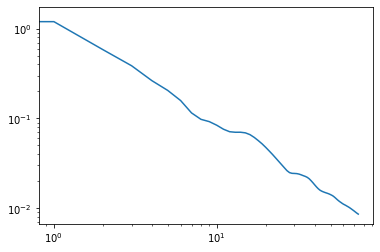

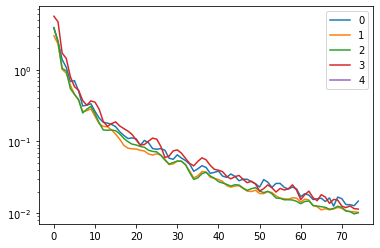

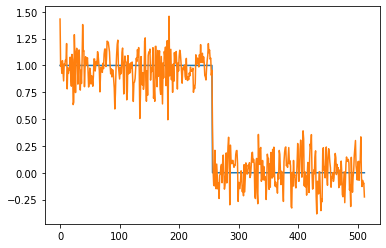

Relative error: 0.1279128


In [11]:
netcopy = copy.deepcopy(net)

mse, msetruth, ni, netcopy, out_grads, out_norms = fit(netcopy,y,ystep,num_channels,net_input=ni,num_iter = 75,LR = 0.01,upsamplefactor=ups)

plt.loglog(mse)
plt.show()

yy_np = netcopy(ni).type(dtype).data.cpu().numpy()[0,0]
plot_gradients(out_grads)

plt.plot(ystep_np)
plt.plot(yy_np)
plt.show()

print("Relative error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )

In [12]:
jacTT = get_jacobian(netcopy,ni)
UTT,STT,VtTT = np.linalg.svd(jacTT)

## Jacobian after training the network for long

input provided


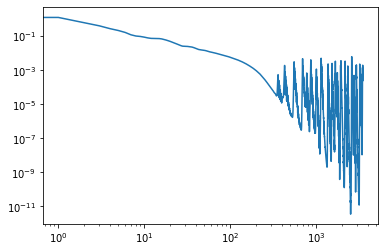

Error: 0.047214214


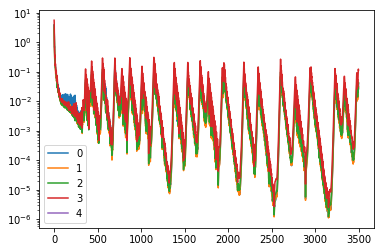

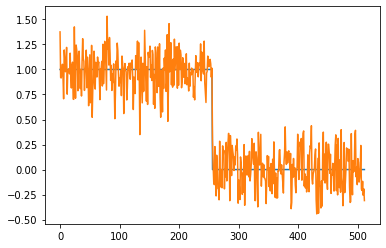

In [13]:
mse,msetruth, ni, net, out_grads, out_norms = fit(net,y,ystep,num_channels,net_input=ni,num_iter = 3500,LR = 0.01,upsamplefactor=ups)

plt.loglog(mse)
plt.show()

yy_np = net(ni).type(dtype).data.cpu().numpy()[0,0]
print("Error:", np.linalg.norm(yy_np - y_np)/np.linalg.norm(y_np) )
plot_gradients(out_grads)

plt.plot(ystep_np)
plt.plot(yy_np)
plt.show()

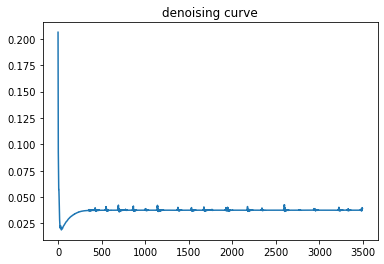

In [14]:
plt.plot(msetruth[5:])
plt.title("denoising curve")
plt.show()

### Jacobian of trained network

In [15]:
jacT = get_jacobian(net,ni)
UT,ST,VtT = np.linalg.svd(jacT)

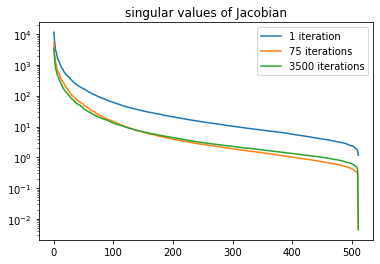

In [16]:
plt.plot(S,label='1 iteration')
plt.plot(STT,label='75 iterations')
plt.plot(ST,label='3500 iterations')
plt.yscale('log')
plt.legend()
plt.title("singular values of Jacobian")
plt.show()

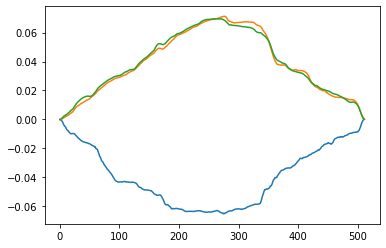

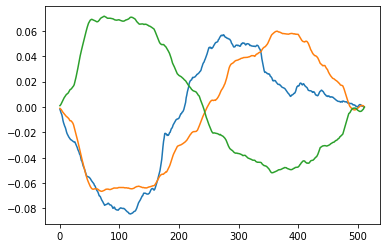

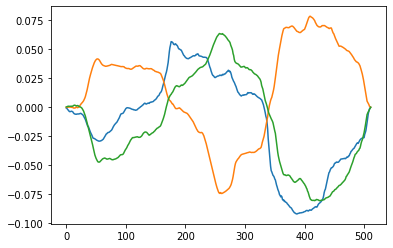

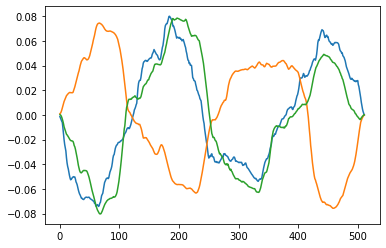

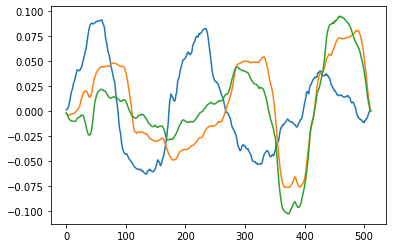

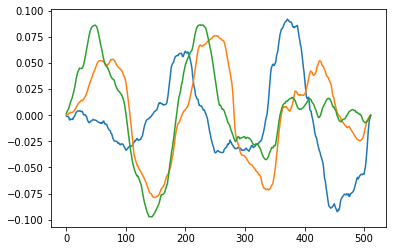

In [17]:
plt.plot(U.T[0])
plt.plot(UTT.T[0])
plt.plot(UT.T[0])
plt.show()

plt.plot(U.T[1])
plt.plot(UTT.T[1])
plt.plot(-UT.T[1])
plt.show()

plt.plot(U.T[2])
plt.plot(UTT.T[2])
plt.plot(-UT.T[2])
plt.show()

plt.plot(U.T[3])
plt.plot(UTT.T[3])
plt.plot(UT.T[3])
plt.show()

plt.plot(U.T[4])
plt.plot(UTT.T[4])
plt.plot(UT.T[4])
plt.show()

plt.plot(U.T[5])
plt.plot(UTT.T[5])
plt.plot(UT.T[5])
plt.show()


top6 = [U.T[0],UTT.T[0],UT.T[0], 
        U.T[1],UTT.T[1],-UT.T[1],
        U.T[2],UTT.T[2],-UT.T[2],
        U.T[3],UTT.T[3],UT.T[3],
        U.T[4],UTT.T[4],UT.T[4],
        U.T[5],UTT.T[5],UT.T[5] ]

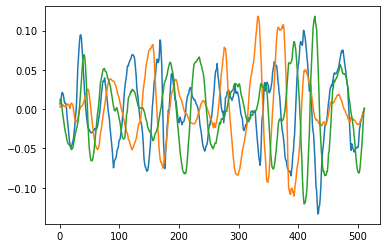

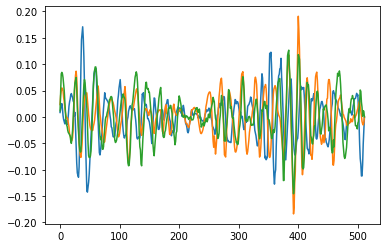

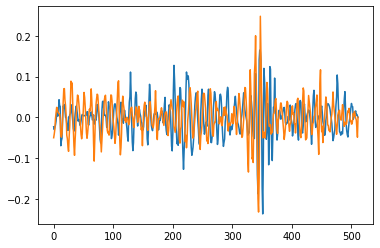

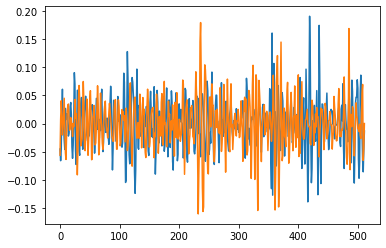

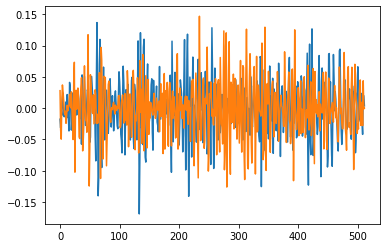

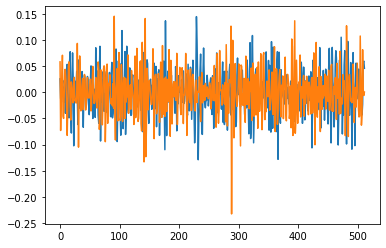

In [18]:
plt.plot(U.T[20])
plt.plot(-UTT.T[20])
plt.plot(-UT.T[20])
plt.show()


plt.plot(U.T[50])
plt.plot(-UTT.T[50])
plt.plot(UT.T[50])
plt.show()

plt.plot(U.T[100])
plt.plot(-UT.T[100])
plt.show()

plt.plot(U.T[150])
plt.plot(-UT.T[150])
plt.show()

plt.plot(U.T[200])
plt.plot(-UT.T[200])
plt.show()

plt.plot(U.T[250])
plt.plot(-UT.T[250])
plt.show()

### Write to file

In [30]:
def res_to_mtx(losses,filename):
    ks = [i for i in range(len(losses[0]))]
    A = [np.array(ks)]
    A += losses
    A = np.vstack( A ).T
    print(A.shape)
    np.savetxt(filename, A, delimiter=' ')

top6 = [U.T[0],UTT.T[0],UT.T[0], 
        U.T[1],UTT.T[1],-UT.T[1],
        U.T[2],UTT.T[2],-UT.T[2],
        U.T[3],UTT.T[3],UT.T[3],
        U.T[4],UTT.T[4],UT.T[4],
        U.T[5],UTT.T[5],UT.T[5] ]
other6 = [U.T[20],UT.T[20],U.T[50],-UT.T[50],U.T[100],-UT.T[100],U.T[150],-UT.T[150],U.T[200],-UT.T[200],U.T[250],-UT.T[250]]

In [37]:
res_to_mtx(top6,"JacobianTop6.dat")
res_to_mtx(other6,"JacobianOther6.dat")
res_to_mtx([S,STT,ST],"JacobianSingularVal.dat")

(512, 19)
(512, 13)
(512, 4)
